# Probe1 Train Probe2 Test on ADC1 @ 10 MSPS

✅ Loaded Probe2 ADC1 CH1: (3332, 38)
✅ Loaded Probe2 ADC1 CH2: (3331, 38)
✅ Loaded Probe1 ADC1 CH1: (3332, 38)
✅ Loaded Probe1 ADC1 CH2: (3332, 38)

Verifying ADC Consistency...
✅ Using ADC 1 for both training (Probe2) and testing (Probe1).

Test Accuracy: 1.0000
              precision    recall  f1-score   support

         CH1       1.00      1.00      1.00      3332
         CH2       1.00      1.00      1.00      3332

    accuracy                           1.00      6664
   macro avg       1.00      1.00      1.00      6664
weighted avg       1.00      1.00      1.00      6664



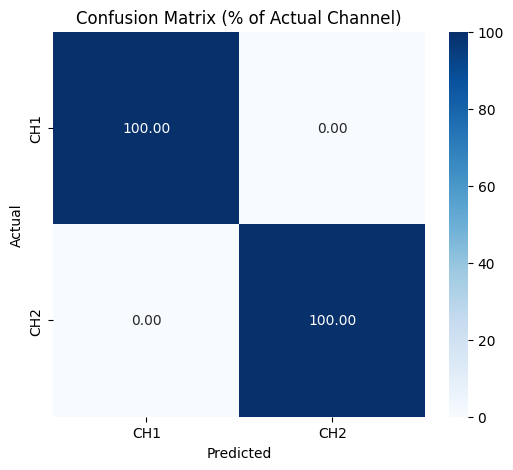

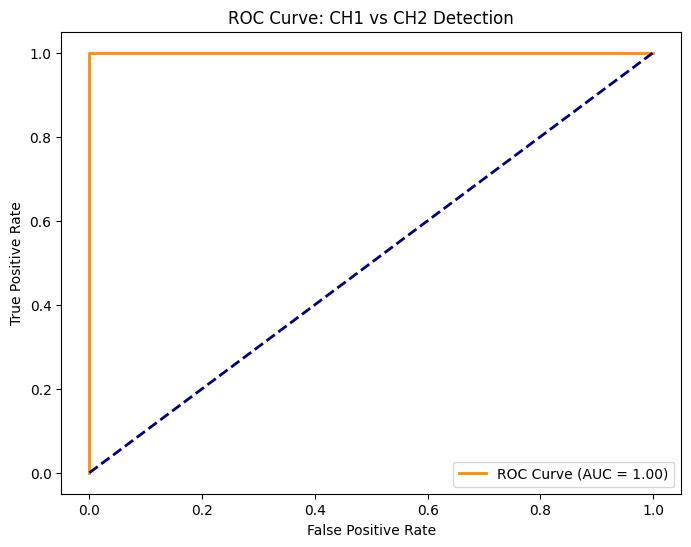

In [1]:
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)

# ==================================================================
# Configuration: Select ADC Number
# ==================================================================
base_directory = "C:\\Users\\awm21\\Documents\\Probe_Vari\\Neural_Networks\\Features_Vitis"

# Change this value to test different ADCs
adc_num = int(input("Enter ADC number to test: "))  # User input for ADC selection

def load_channel_data(probe_name, adc_num, channel):
    """Load specific ADC/channel data for a probe and verify ADC consistency."""
    folder = os.path.join(base_directory, f"P{probe_name[-1]}_fd")  # e.g., P1_fd for Probe1
    filename = f'fd_{probe_name}_ADC{adc_num}_CH{channel}_30_MSPS.npy'
    file_path = os.path.join(folder, filename)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    data = np.load(file_path)
    print(f"✅ Loaded {probe_name} ADC{adc_num} CH{channel}: {data.shape}")  # Verification print
    return data

# ==================================================================
# Training Data (Probe1)
# ==================================================================
train_probe = "Probe2"
train_ch0 = load_channel_data(train_probe, adc_num, 1)  # CH1 = label 0
train_ch1 = load_channel_data(train_probe, adc_num, 2)  # CH2 = label 1

X_train = np.vstack([train_ch0, train_ch1])
y_train = np.concatenate([
    np.zeros(train_ch0.shape[0]),  # Label 0 for CH1
    np.ones(train_ch1.shape[0])    # Label 1 for CH2
])

# ==================================================================
# Test Data (Probe3)
# ==================================================================
test_probe = "Probe1"
test_ch0 = load_channel_data(test_probe, adc_num, 1)  # CH1 = label 0
test_ch1 = load_channel_data(test_probe, adc_num, 2)  # CH2 = label 1

X_test = np.vstack([test_ch0, test_ch1])
y_test = np.concatenate([
    np.zeros(test_ch0.shape[0]),  # Label 0 for CH1
    np.ones(test_ch1.shape[0])    # Label 1 for CH2
])

# ==================================================================
# Verify ADC Consistency
# ==================================================================
print("\nVerifying ADC Consistency...")
if train_probe != test_probe:
    print(f"✅ Using ADC {adc_num} for both training ({train_probe}) and testing ({test_probe}).")
else:
    print(f"⚠️ Warning: Training and testing are from the same probe {train_probe}.")

# ==================================================================
# Model Training & Evaluation
# ==================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Save artifacts
os.makedirs("Models/Probe_Test", exist_ok=True)
joblib.dump(clf, "Models/Probe_Test/ADC1_30_p2tp1t.pkl")
joblib.dump(scaler, "Models/Probe_Test/ADC1_30_p2tp1t.pkl")

# Generate predictions
y_pred = clf.predict(X_test_scaled)
y_probs = clf.predict_proba(X_test_scaled)[:, 1]

# ==================================================================
# Performance Visualization
# ==================================================================
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['CH1', 'CH2']))

# Confusion Matrix (%)
def plot_confusion_matrix_percentage(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=['CH1', 'CH2'], 
                yticklabels=['CH1', 'CH2'])
    plt.title("Confusion Matrix (% of Actual Channel)")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

plot_confusion_matrix_percentage(y_test, y_pred)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: CH1 vs CH2 Detection')
plt.legend(loc="lower right")
plt.show()


# Probe1 Train Probe3 Test on ADC1 @ 10 MSPS

✅ Loaded Probe2 ADC1 CH1: (3332, 38)
✅ Loaded Probe2 ADC1 CH2: (3331, 38)
✅ Loaded Probe3 ADC1 CH1: (3331, 38)
✅ Loaded Probe3 ADC1 CH2: (3332, 38)

Verifying ADC Consistency...
✅ Using ADC 1 for both training (Probe2) and testing (Probe3).

Test Accuracy: 0.9968
              precision    recall  f1-score   support

         CH1       1.00      1.00      1.00      3331
         CH2       1.00      1.00      1.00      3332

    accuracy                           1.00      6663
   macro avg       1.00      1.00      1.00      6663
weighted avg       1.00      1.00      1.00      6663



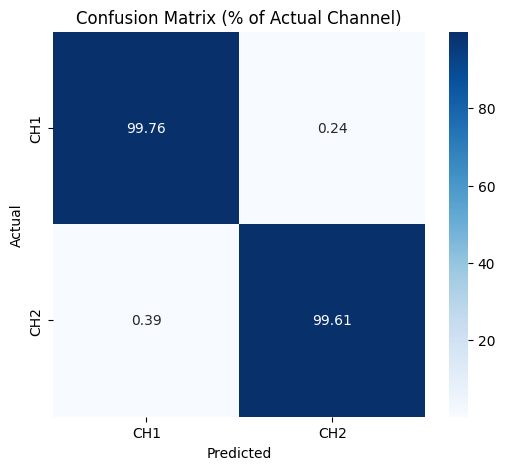

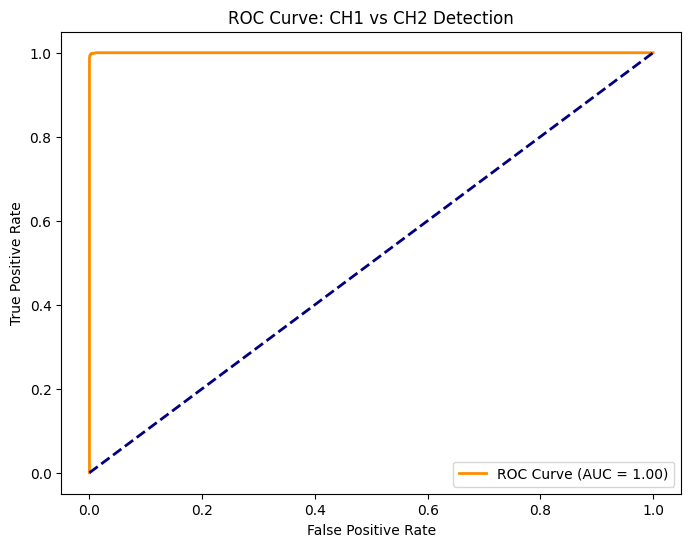

In [2]:
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)

# ==================================================================
# Configuration: Select ADC Number
# ==================================================================
base_directory = "C:\\Users\\awm21\\Documents\\Probe_Vari\\Neural_Networks\\Features_Vitis"

# Change this value to test different ADCs
adc_num = int(input("Enter ADC number to test: "))  # User input for ADC selection

def load_channel_data(probe_name, adc_num, channel):
    """Load specific ADC/channel data for a probe and verify ADC consistency."""
    folder = os.path.join(base_directory, f"P{probe_name[-1]}_fd")  # e.g., P1_fd for Probe1
    filename = f'fd_{probe_name}_ADC{adc_num}_CH{channel}_30_MSPS.npy'
    file_path = os.path.join(folder, filename)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    data = np.load(file_path)
    print(f"✅ Loaded {probe_name} ADC{adc_num} CH{channel}: {data.shape}")  # Verification print
    return data

# ==================================================================
# Training Data (Probe1)
# ==================================================================
train_probe = "Probe2"
train_ch0 = load_channel_data(train_probe, adc_num, 1)  # CH1 = label 0
train_ch1 = load_channel_data(train_probe, adc_num, 2)  # CH2 = label 1

X_train = np.vstack([train_ch0, train_ch1])
y_train = np.concatenate([
    np.zeros(train_ch0.shape[0]),  # Label 0 for CH1
    np.ones(train_ch1.shape[0])    # Label 1 for CH2
])

# ==================================================================
# Test Data (Probe3)
# ==================================================================
test_probe = "Probe3"
test_ch0 = load_channel_data(test_probe, adc_num, 1)  # CH1 = label 0
test_ch1 = load_channel_data(test_probe, adc_num, 2)  # CH2 = label 1

X_test = np.vstack([test_ch0, test_ch1])
y_test = np.concatenate([
    np.zeros(test_ch0.shape[0]),  # Label 0 for CH1
    np.ones(test_ch1.shape[0])    # Label 1 for CH2
])

# ==================================================================
# Verify ADC Consistency
# ==================================================================
print("\nVerifying ADC Consistency...")
if train_probe != test_probe:
    print(f"✅ Using ADC {adc_num} for both training ({train_probe}) and testing ({test_probe}).")
else:
    print(f"⚠️ Warning: Training and testing are from the same probe {train_probe}.")

# ==================================================================
# Model Training & Evaluation
# ==================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Save artifacts
os.makedirs("Models/Probe_Test", exist_ok=True)
joblib.dump(clf, "Models/Probe_Test/ADC1_30_p2tp3t.pkl")
joblib.dump(scaler, "Models/Probe_Test/ADC1_30_p2tp3t.pkl")

# Generate predictions
y_pred = clf.predict(X_test_scaled)
y_probs = clf.predict_proba(X_test_scaled)[:, 1]

# ==================================================================
# Performance Visualization
# ==================================================================
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['CH1', 'CH2']))

# Confusion Matrix (%)
def plot_confusion_matrix_percentage(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=['CH1', 'CH2'], 
                yticklabels=['CH1', 'CH2'])
    plt.title("Confusion Matrix (% of Actual Channel)")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

plot_confusion_matrix_percentage(y_test, y_pred)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: CH1 vs CH2 Detection')
plt.legend(loc="lower right")
plt.show()
